<a href="https://colab.research.google.com/github/bleenee203/IS335.P11---SQLi/blob/kthanh/Word2vec_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf

# Mount drive and load data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
data_path = '/content/drive/My Drive/Data/Modified_SQL_Dataset_preprocessed.csv'
data = pd.read_csv(data_path)

# Preprocess the Query data
data['Query'] = data['Query'].fillna('').apply(str)
queries = data['Query'].apply(lambda x: x.lower().split())
labels = data['Label'].values
y = labels  # Assign labels to y

# Step 2: Train Word2Vec Model
from gensim.models import Word2Vec
word2vec_model = Word2Vec(sentences=queries, vector_size=200, min_count=1, window=5, sg=1)

# Save word embeddings to use in LSTM
vocab_size = len(word2vec_model.wv)
embedding_dim = word2vec_model.vector_size

# Step 3: Prepare Data for LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Query'])
sequences = tokenizer.texts_to_sequences(data['Query'])

# Padding sequences to ensure consistent input shape for LSTM
max_sequence_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Map Word2Vec embeddings to Keras Embedding layer
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Step 4: Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

batch_sizes = [16, 32, 64, 128]
best_batch_size = None
best_accuracy = 0

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X, y, epochs=10, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation Accuracy: {val_accuracy}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_batch_size = batch_size

print(f"Best Batch Size: {best_batch_size}, Best Validation Accuracy: {best_accuracy}")


Mounted at /content/drive
Training with batch size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation Accuracy: 0.9998382925987244
Training with batch size: 32
Validation Accuracy: 0.9993531703948975
Training with batch size: 64
Validation Accuracy: 0.9985446333885193
Training with batch size: 128
Validation Accuracy: 0.9995148777961731
Best Batch Size: 16, Best Validation Accuracy: 0.9998382925987244


Epoch 1/20
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.9803 - loss: 0.0778 - val_accuracy: 0.9985 - val_loss: 0.0037
Epoch 2/20
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9855 - loss: 0.0568 - val_accuracy: 0.9990 - val_loss: 0.0027
Epoch 3/20
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.9863 - loss: 0.0504 - val_accuracy: 0.9982 - val_loss: 0.0053
Epoch 4/20
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.9889 - loss: 0.0449 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 5/20
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.9890 - loss: 0.0426 - val_accuracy: 0.9981 - val_loss: 0.0095


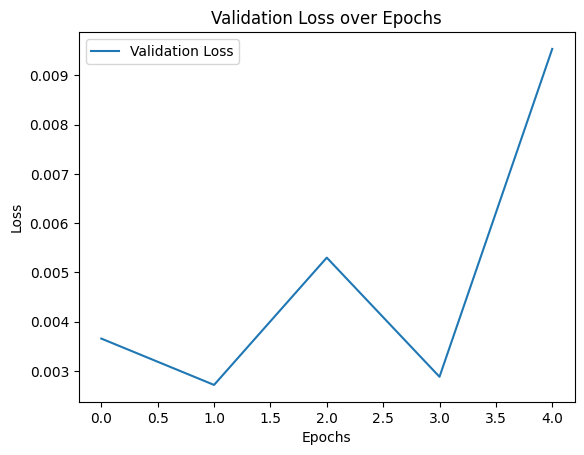

Best Epoch: 2


In [ ]:

# Using the best batch size found earlier
batch_size = best_batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X, y, epochs=20, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

# Plot validation loss to find the optimal epoch
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss over Epochs')
plt.show()

# Find the best epoch
best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"Best Epoch: {best_epoch}")


In [ ]:
from sklearn.metrics import classification_report

# Step 1: Get model predictions on the validation/test set
y_pred = (model.predict(X) > 0.5).astype("int32")  # Use a threshold of 0.5 for binary classification

# Step 2: Print Precision, Recall, and F1-Score
print(classification_report(y, y_pred, target_names=['Non-SQL Injection', 'SQL Injection']))


967/967 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
                   precision    recall  f1-score   support

Non-SQL Injection       0.98      1.00      0.99     19537
    SQL Injection       1.00      0.97      0.98     11382

         accuracy                           0.99     30919
        macro avg       0.99      0.98      0.99     30919
     weighted avg       0.99      0.99      0.99     30919



check for overfitting

Epoch 1/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9856 - loss: 0.0549 - val_accuracy: 0.9900 - val_loss: 0.0403
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9792 - loss: 0.0871 - val_accuracy: 0.9989 - val_loss: 0.0045
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9839 - loss: 0.0614 - val_accuracy: 0.9987 - val_loss: 0.0048
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9850 - loss: 0.0568 - val_accuracy: 0.9964 - val_loss: 0.0153
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9860 - loss: 0.0556 - val_accuracy: 0.9990 - val_loss: 0.0041
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9867 - loss: 0.0528 - val_accuracy: 0.9966 - val_loss: 0.0156
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9862 - loss: 0.0519 - val_accuracy: 0.9973 - val_loss: 0.0107
Epoch 8/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9872 - loss: 0.0523 - 

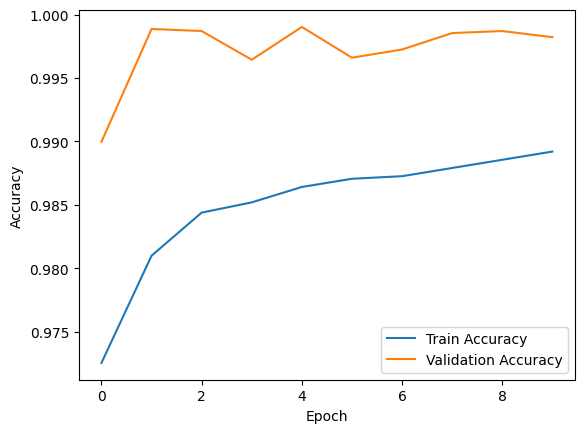

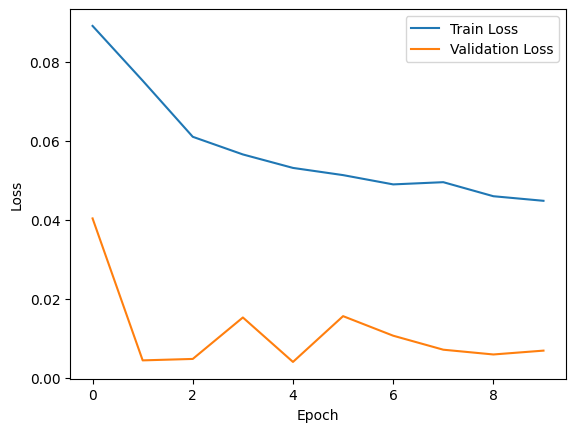

In [ ]:
import matplotlib.pyplot as plt

history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Lưu model để chạy thực nghiệm
model.save("lstm.h5")